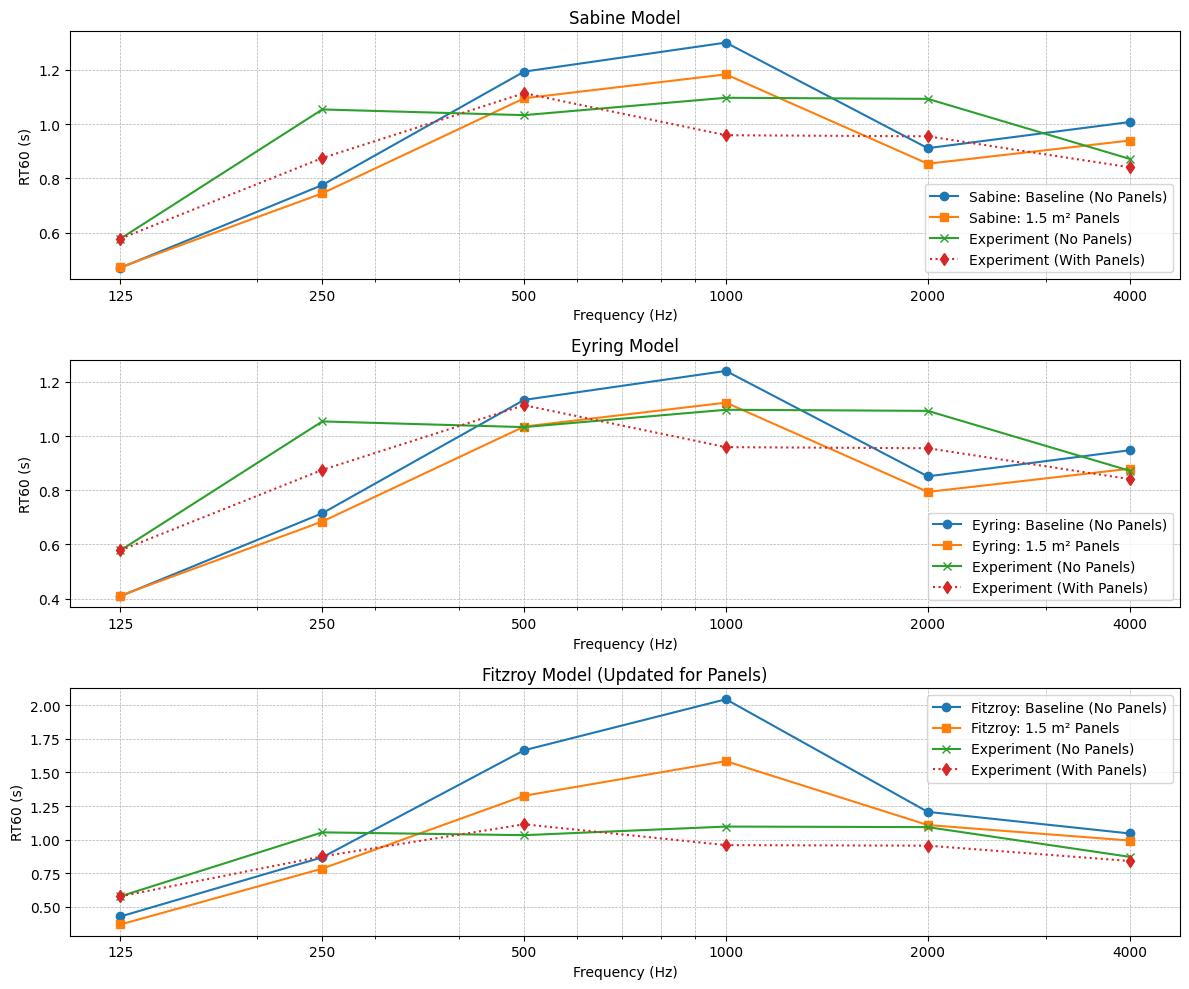

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Room dimensions in meters
width = 3.10
length = 9.65
height = 3.89

# Surface areas (m²)
floor_ceiling_area = width * length
front_back_wall_area = width * height
left_right_wall_area = length * height

# Define areas for each set of surfaces
Sx = 2 * left_right_wall_area   # Walls perpendicular to x-axis
Sy = 2 * front_back_wall_area   # Walls perpendicular to y-axis
Sz = 2 * floor_ceiling_area     # Floor and ceiling
total_surface_area = Sx + Sy + Sz

# Room volume (m³)
volume = width * length * height

# Frequency bands (Hz)
frequencies = np.array([125, 250, 500, 1000, 2000, 4000])

#Experimental data
RT60_absorber=np.array([0.578,0.875,1.114,.959,.955,.841]) #with absorber
RT60_baseline=np.array([0.578,1.054,1.033,1.097,1.093,0.872]) # without absorber
# Baseline absorption coefficients for the surfaces:
# Assume walls are drywall, floor is concrete, ceiling is perforated steel.
alpha_drywall = np.array([0.29, 0.10, 0.05, 0.04, 0.07, 0.09])
alpha_concrete = np.array([0.36, 0.44, 0.31, 0.29, 0.39, 0.25])


# The grid itself contributes minimal absorption, so we approximate the ceiling absorption as mostly concrete.
alpha_steel_grid = np.array([0.02, 0.04, 0.05, 0.06, 0.07, 0.08])  # Approximate absorption of a steel grid

# Surface areas for each material:
area_drywall = Sx + Sy            # Walls (drywall)
area_concrete = floor_ceiling_area  # Floor
area_perforated_steel = floor_ceiling_area  # Ceiling

# Effective absorption for the ceiling considering the steel grid
alpha_ceiling = (alpha_concrete + alpha_steel_grid) / 2.0

# Define absorption coefficients for glass
alpha_glass = np.array([0.18, 0.06, 0.04, 0.03, 0.02, 0.02])  # Approximate absorption of a glass wall

# Update the area calculations
area_glass = front_back_wall_area  # The front wall is glass
area_drywall_new = area_drywall - area_glass  # Adjust drywall area

# Update the effective absorption coefficients
effective_alpha_y = ((area_glass * alpha_glass) + (area_drywall_new * alpha_drywall)) / (area_glass + area_drywall_new)

# Recalculate the total absorption in sabins
A_baseline = (Sx * alpha_drywall) + (Sy * effective_alpha_y) + (Sz * alpha_ceiling)


# Define absorption coefficients for 2-inch thick fiberglass panels:
alpha_fiberglass = np.array([0.18, 0.76, 0.99, 0.99, 0.99, 0.99])

# Suppose 1.5 m² of the drywall (wall surface) is replaced with fiberglass panels.
panel_area = 1.5  # m²

# For Sabine/Eyring models, update total absorption:
A_new = A_baseline + panel_area * (alpha_fiberglass - alpha_drywall)

# Mean absorption coefficients (averaged over total surface area)
mean_alpha_baseline = A_baseline / total_surface_area
mean_alpha_new = A_new / total_surface_area

# Calculate RT60 using the Sabine formula for each frequency band:
RT60_sabine_baseline = 0.161 * volume / A_baseline
RT60_sabine_new = 0.161 * volume / A_new

# Calculate RT60 using the Eyring formula:
RT60_eyring_baseline = 0.161 * volume / (-total_surface_area * np.log(1 - mean_alpha_baseline + 1e-12))
RT60_eyring_new = 0.161 * volume / (-total_surface_area * np.log(1 - mean_alpha_new + 1e-12))

# For the Fitzroy model, update to account for the fiberglass panels on the walls.
RT60_fitzroy_baseline = []
RT60_fitzroy_new = []

for i in range(len(frequencies)):
    # Baseline Fitzroy using original absorption values:
    rt_fitzroy_base = 0.161 * volume / (total_surface_area**2) * (
        (Sx / (-np.log(1 - alpha_drywall[i] + 1e-12))) +
        (Sy / (-np.log(1 - effective_alpha_y[i] + 1e-12))) +
        (Sz / (-np.log(1 - alpha_ceiling[i] + 1e-12)))
    )
    RT60_fitzroy_baseline.append(rt_fitzroy_base)
    
    # New effective absorption for walls:
    # Only a portion of the drywall area (panel_area) is replaced.
    # Effective absorption for side walls (X-axis) - remains drywall and fiberglass only
    effective_alpha_x = (
        ((Sx - panel_area) * alpha_drywall[i]) + 
        (panel_area * alpha_fiberglass[i]) 
    ) / Sx

    # Effective absorption for front & back walls (Y-axis) - includes glass on front wall
    effective_alpha_y_new = (
        ((Sy - area_glass) * alpha_drywall[i]) + 
        (area_glass * alpha_glass[i])
    ) / Sy

    # Floor and ceiling remain unchanged:
    effective_alpha_floor = alpha_concrete[i]
    effective_alpha_ceiling = alpha_ceiling[i]
    effective_alpha_fc = (effective_alpha_floor + effective_alpha_ceiling) / 2.0

    rt_fitzroy_new_val = 0.161 * volume / (total_surface_area**2) * (
        (Sx / (-np.log(1 - effective_alpha_x + 1e-12))) +
        (Sy / (-np.log(1 - effective_alpha_y_new + 1e-12))) +
        (Sz / (-np.log(1 - effective_alpha_fc + 1e-12)))
    )
    RT60_fitzroy_new.append(rt_fitzroy_new_val)

# Plotting the RT60 curves for baseline and for the 1.5 m² panel case

plt.figure(figsize=(12, 10))

# Sabine Model
plt.subplot(3, 1, 1)
plt.plot(frequencies, RT60_sabine_baseline, 'o-', label='Sabine: Baseline (No Panels)')
plt.plot(frequencies, RT60_sabine_new, 's-', label='Sabine: 1.5 m² Panels')
plt.plot(frequencies, RT60_baseline, 'x-', label='Experiment (No Panels)')
plt.plot(frequencies, RT60_absorber, 'd:', label='Experiment (With Panels)')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('RT60 (s)')
plt.title('Sabine Model')
plt.xticks(frequencies, labels=[str(f) for f in frequencies])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Eyring Model
plt.subplot(3, 1, 2)
plt.plot(frequencies, RT60_eyring_baseline, 'o-', label='Eyring: Baseline (No Panels)')
plt.plot(frequencies, RT60_eyring_new, 's-', label='Eyring: 1.5 m² Panels')
plt.plot(frequencies, RT60_baseline, 'x-', label='Experiment (No Panels)')
plt.plot(frequencies, RT60_absorber, 'd:', label='Experiment (With Panels)')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('RT60 (s)')
plt.title('Eyring Model')
plt.xticks(frequencies, labels=[str(f) for f in frequencies])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Fitzroy Model (Updated to include panel effect)
plt.subplot(3, 1, 3)
plt.plot(frequencies, RT60_fitzroy_baseline, 'o-', label='Fitzroy: Baseline (No Panels)')
plt.plot(frequencies, RT60_fitzroy_new, 's-', label='Fitzroy: 1.5 m² Panels')
plt.plot(frequencies, RT60_baseline, 'x-', label='Experiment (No Panels)')
plt.plot(frequencies, RT60_absorber, 'd:', label='Experiment (With Panels)')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('RT60 (s)')
plt.title('Fitzroy Model (Updated for Panels)')
plt.xticks(frequencies, labels=[str(f) for f in frequencies])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# Calculate percentage difference
def percentage_difference(theoretical, experimental):
    return np.abs(theoretical - experimental) / experimental * 100

# Creating a DataFrame
df = pd.DataFrame({
    'Frequency (Hz)': frequencies,
    'Sabine % Diff (No Panels)': percentage_difference(RT60_sabine_baseline, RT60_baseline),
    'Sabine % Diff (With Panels)': percentage_difference(RT60_sabine_new, RT60_absorber),
    'Eyring % Diff (No Panels)': percentage_difference(RT60_eyring_baseline, RT60_baseline),
    'Eyring % Diff (With Panels)': percentage_difference(RT60_eyring_new, RT60_absorber),
    'Fitzroy % Diff (No Panels)': percentage_difference(RT60_fitzroy_baseline, RT60_baseline),
    'Fitzroy % Diff (With Panels)': percentage_difference(RT60_fitzroy_new, RT60_absorber)
})


# Display the DataFrame
display(df)


,Frequency (Hz),Sabine % Diff (No Panels),Sabine % Diff (With Panels),Eyring % Diff (No Panels),Eyring % Diff (With Panels),Fitzroy % Diff (No Panels),Fitzroy % Diff (With Panels)
0,125,18.581033,18.242187,29.261377,28.920191,25.963621,36.259954
1,250,26.429889,14.867788,32.172254,21.793132,17.632156,10.398604
2,500,15.523200,1.704509,9.721880,7.092717,61.179982,19.059037
3,1000,18.531055,23.385078,13.076212,17.135150,86.385952,65.170574
4,2000,16.619497,10.573741,22.133307,16.894598,10.387123,16.085082
5,4000,15.549771,11.699325,8.654380,4.538497,19.929010,18.098514


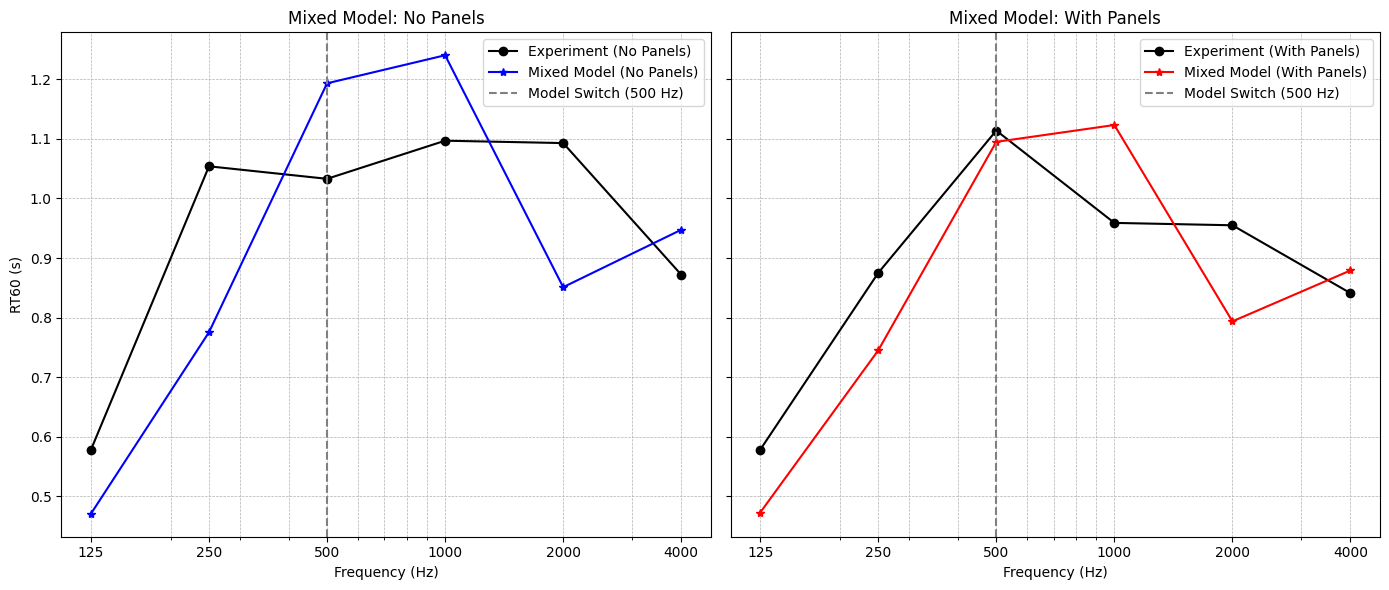

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Room dimensions
width, length, height = 3.10, 9.65, 3.89

# Surface areas and volume
floor_ceiling_area = width * length
front_back_wall_area = width * height
left_right_wall_area = length * height
Sx = 2 * left_right_wall_area
Sy = 2 * front_back_wall_area
Sz = 2 * floor_ceiling_area
total_surface_area = Sx + Sy + Sz
volume = width * length * height

# Frequencies and experimental data
frequencies = np.array([125, 250, 500, 1000, 2000, 4000])
RT60_absorber = np.array([0.578, 0.875, 1.114, 0.959, 0.955, 0.841])
RT60_baseline = np.array([0.578, 1.054, 1.033, 1.097, 1.093, 0.872])

# Absorption coefficients
alpha_drywall = np.array([0.29, 0.10, 0.05, 0.04, 0.07, 0.09])
alpha_concrete = np.array([0.36, 0.44, 0.31, 0.29, 0.39, 0.25])
alpha_steel_grid = np.array([0.02, 0.04, 0.05, 0.06, 0.07, 0.08])
alpha_ceiling = (alpha_concrete + alpha_steel_grid) / 2.0
alpha_glass = np.array([0.18, 0.06, 0.04, 0.03, 0.02, 0.02])
alpha_fiberglass = np.array([0.18, 0.76, 0.99, 0.99, 0.99, 0.99])

# Area adjustments
area_drywall = Sx + Sy
area_concrete = floor_ceiling_area
area_perforated_steel = floor_ceiling_area
area_glass = front_back_wall_area
area_drywall_new = area_drywall - area_glass
effective_alpha_y = ((area_glass * alpha_glass) + (area_drywall_new * alpha_drywall)) / (area_glass + area_drywall_new)

# Absorption
A_baseline = (Sx * alpha_drywall) + (Sy * effective_alpha_y) + (Sz * alpha_ceiling)
panel_area = 1.5
A_new = A_baseline + panel_area * (alpha_fiberglass - alpha_drywall)
mean_alpha_baseline = A_baseline / total_surface_area
mean_alpha_new = A_new / total_surface_area

# Sabine and Eyring models
RT60_sabine_baseline = 0.161 * volume / A_baseline
RT60_eyring_baseline = 0.161 * volume / (-total_surface_area * np.log(1 - mean_alpha_baseline + 1e-12))
RT60_sabine_new = 0.161 * volume / A_new
RT60_eyring_new = 0.161 * volume / (-total_surface_area * np.log(1 - mean_alpha_new + 1e-12))

# Mixed model switch
cutoff_freq = 500
mixed_rt60_baseline = np.where(frequencies <= cutoff_freq, RT60_sabine_baseline, RT60_eyring_baseline)
mixed_rt60_new = np.where(frequencies <= cutoff_freq, RT60_sabine_new, RT60_eyring_new)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for No Panels
axs[0].plot(frequencies, RT60_baseline, 'ko-', label='Experiment (No Panels)')
axs[0].plot(frequencies, mixed_rt60_baseline, 'b*-', label='Mixed Model (No Panels)')
axs[0].axvline(cutoff_freq, color='gray', linestyle='--', label='Model Switch (500 Hz)')
axs[0].set_xscale('log')
axs[0].set_xticks(frequencies)
axs[0].set_xticklabels([str(f) for f in frequencies])
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('RT60 (s)')
axs[0].set_title('Mixed Model: No Panels')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].legend()

# Plot for With Panels
axs[1].plot(frequencies, RT60_absorber, 'ko-', label='Experiment (With Panels)')
axs[1].plot(frequencies, mixed_rt60_new, 'r*-', label='Mixed Model (With Panels)')
axs[1].axvline(cutoff_freq, color='gray', linestyle='--', label='Model Switch (500 Hz)')
axs[1].set_xscale('log')
axs[1].set_xticks(frequencies)
axs[1].set_xticklabels([str(f) for f in frequencies])
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_title('Mixed Model: With Panels')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# Percentage difference formula: |theoretical - experimental| / experimental * 100
def percentage_difference(theoretical, experimental):
    return np.abs(theoretical - experimental) / experimental * 100

# Compute differences
baseline_diff = percentage_difference(mixed_rt60_baseline, RT60_baseline)
absorber_diff = percentage_difference(mixed_rt60_new, RT60_absorber)

# Create DataFrames
df_baseline = pd.DataFrame({
    'Frequency (Hz)': frequencies,
    'RT60 Exp (No Panels)': RT60_baseline,
    'RT60 Mixed Model': mixed_rt60_baseline,
    '% Difference': baseline_diff
})

df_absorber = pd.DataFrame({
    'Frequency (Hz)': frequencies,
    'RT60 Exp (With Panels)': RT60_absorber,
    'RT60 Mixed Model': mixed_rt60_new,
    '% Difference': absorber_diff
})

print("Baseline and Absorber Model Comparison")
display(df_baseline)
print("Absorber Panel Model Comparison")
display(df_absorber)


Baseline and Absorber Model Comparison


,Frequency (Hz),RT60 Exp (No Panels),RT60 Mixed Model,% Difference
0,125,0.578,0.470602,18.581033
1,250,1.054,0.775429,26.429889
2,500,1.033,1.193355,15.523200
3,1000,1.097,1.240446,13.076212
4,2000,1.093,0.851083,22.133307
5,4000,0.872,0.947466,8.654380


Absorber Panel Model Comparison


,Frequency (Hz),RT60 Exp (With Panels),RT60 Mixed Model,% Difference
0,125,0.578,0.472560,18.242187
1,250,0.875,0.744907,14.867788
2,500,1.114,1.095012,1.704509
3,1000,0.959,1.123326,17.135150
4,2000,0.955,0.793657,16.894598
5,4000,0.841,0.879169,4.538497


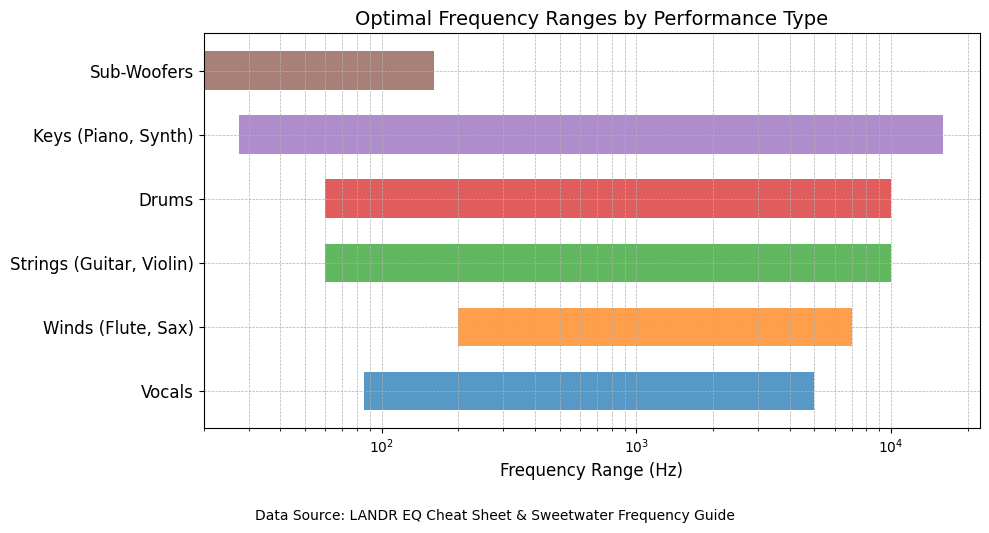

In [4]:
import matplotlib.pyplot as plt

# Define performance types and their optimal frequency ranges
performance_types = [
    "Vocals",
    "Winds (Flute, Sax)",
    "Strings (Guitar, Violin)",
    "Drums",
    "Keys (Piano, Synth)",
    "Sub-Woofers"
]

# Frequency ranges in Hz from trusted online sources
frequency_ranges = [
    (85, 5000),       # Vocals
    (200, 7000),      # Winds
    (60, 10000),      # Strings
    (60, 10000),      # Drums
    (27.5, 16000),    # Keys
    (20, 160)         # Sub-Woofers
]

# Positions for the bars on the y-axis
y_positions = list(range(len(performance_types)))

# Plot setup
plt.figure(figsize=(10, 5))

# Plot each frequency range as a horizontal bar
for i, (start, end) in enumerate(frequency_ranges):
    plt.barh(y_positions[i], end - start, left=start, height=0.6, alpha=0.75)

# Chart formatting
plt.yticks(y_positions, performance_types, fontsize=12)
plt.xlabel("Frequency Range (Hz)", fontsize=12)
plt.title("Optimal Frequency Ranges by Performance Type", fontsize=14)
plt.xscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Add source note
plt.figtext(0.5, -0.05,
            "Data Source: LANDR EQ Cheat Sheet & Sweetwater Frequency Guide",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()
